### **`Dependencies`**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import warnings

import pandas as pd
import plotly.express as px

from plotly.graph_objects import Figure

from src.data import fetch_data, transform_data
from src.inference import generate_multi_step_forecast
from src.model import compute_metrics, load_model
from src.monitor import backtest_model, evaluate_model
from src.utils import plot_time_series_splits

warnings.filterwarnings("ignore")

In [3]:
# set the pd.DataFrame and pd.Series display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 50)

### **`Feature pipeline`**

In [4]:
# raw data -> pre-processed and validated data -> features and targets
df: pd.DataFrame = fetch_data().pipe(transform_data)
df

2025-02-17 09:44:13.409 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-17 09:44:14.351 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-17 09:44:14.352 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


company_id       timestamp_utc  day_of_week  time_of_day  hour  \
0           aep 2025-02-04 17:00:00            2            2    17   
1           aep 2025-02-04 18:00:00            2            2    18   
2           aep 2025-02-04 19:00:00            2            2    19   
3           aep 2025-02-04 20:00:00            2            2    20   
4           aep 2025-02-04 21:00:00            2            2    21   
...         ...                 ...          ...          ...   ...   
3438       pjmw 2025-02-17 13:00:00            1            1    13   
3439       pjmw 2025-02-17 14:00:00            1            1    14   
3440       pjmw 2025-02-17 15:00:00            1            1    15   
3441       pjmw 2025-02-17 16:00:00            1            1    16   
3442       pjmw 2025-02-17 17:00:00            1            2    17   

      mean_24_lags  std_24_lags  mean_20_lags  std_20_lags  mean_16_lags  \
0     14920.500000  1501.608123      14684.50  1528.239631    14636.8750   
1     14938.333333  1510.154258      14671.30  1516.473857    14820.8125   
2     14957.166667  1526.942517      14714.05  1556.042161    15076.3750   
3     14966.416667  1537.796756      14827.25  1623.011589    15353.1875   
4     14978.541667  1550.701047      14999.25  1629.663281    15624.1875   
...            ...          ...           ...          ...           ...   
3438   4942.666667   561.070612       4820.10   534.539930     4681.3750   
3439   4924.000000   545.807738       4804.30   519.108761     4664.3750   
3440   4902.625000   527.428364       4790.30   506.414237     4647.5000   
3441   4880.375000   511.449161       4774.10   494.081061     4642.2500   
3442   4856.166667   494.155025       4752.40   476.392960     4658.2500   

      std_16_lags  mean_12_lags  std_12_lags  mean_8_lags  std_8_lags  \
0     1620.649453  15349.333333  1161.002493    15917.250  169.433299   
1     1575.799404  15625.500000   747.625392    15914.500  170.724507   
2     1482.733371  15879.250000   337.474881    15966.500  259.765829   
3     1350.749630  16024.750000   323.547699    16051.875  392.909454   
4     1125.781815  16094.416667   370.710732    16130.375  453.906201   
...           ...           ...          ...          ...         ...   
3438   508.406776   4532.166667   472.016724     4701.375  496.194068   
3439   486.307841   4597.166667   499.508637     4837.750  438.832786   
3440   464.419064   4674.750000   499.091925     4955.000  348.117386   
3441   459.824822   4745.000000   475.602393     5035.125  245.145110   
3442   465.129588   4813.083333   432.148850     5084.875  147.561549   

      mean_4_lags  std_4_lags   lag_24   lag_23   lag_22   lag_21   lag_20  \
0        15812.00  156.939479  15407.0  16019.0  16574.0  16402.0  16099.0   
1        15770.75  103.712343  16019.0  16574.0  16402.0  16099.0  15616.0   
2        15918.25  375.694357  16574.0  16402.0  16099.0  15616.0  14532.0   
3        16191.50  531.942666  16402.0  16099.0  15616.0  14532.0  13253.0   
4        16448.75  431.054811  16099.0  15616.0  14532.0  13253.0  12892.0   
...           ...         ...      ...      ...      ...      ...      ...   
3438      5133.25  184.725698   5591.0   5612.0   5516.0   5503.0   5459.0   
3439      5203.50   55.223787   5612.0   5516.0   5503.0   5459.0   5379.0   
3440      5185.25   76.908495   5516.0   5503.0   5459.0   5379.0   5306.0   
3441      5115.50  106.234018   5503.0   5459.0   5379.0   5306.0   5356.0   
3442      5036.50  102.190998   5459.0   5379.0   5306.0   5356.0   5415.0   

       lag_19   lag_18   lag_17   lag_16   lag_15   lag_14   lag_13   lag_12  \
0     15616.0  14532.0  13253.0  12892.0  12382.0  12367.0  12357.0  12521.0   
1     14532.0  13253.0  12892.0  12382.0  12367.0  12357.0  12521.0  13426.0   
2     13253.0  12892.0  12382.0  12367.0  12357.0  12521.0  13426.0  15050.0   
3     12892.0  12382.0  12367.0  12357.0  12521.0  13426.0  15050.0  15857.0   
4     12382.0  12367.0  1

In [5]:
# line plot of each company ID's hourly energy demand
fig: Figure = px.line(
    data_frame=df,
    x="timestamp_utc",
    y="energy_demand_mw",
    color="company_id",
    labels={
        "timestamp_utc": "Timestamp (UTC)",
        "energy_demand_mw": "Energy Demand (MW)",
        "company_id": "Company ID"
    },
    markers=True,
    title="Hourly Energy Demand",
    template="plotly_dark"
)
fig.show()

### **`Training pipeline`**

2025-02-17 09:44:27.877 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-17 09:44:28.705 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-17 09:44:28.706 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


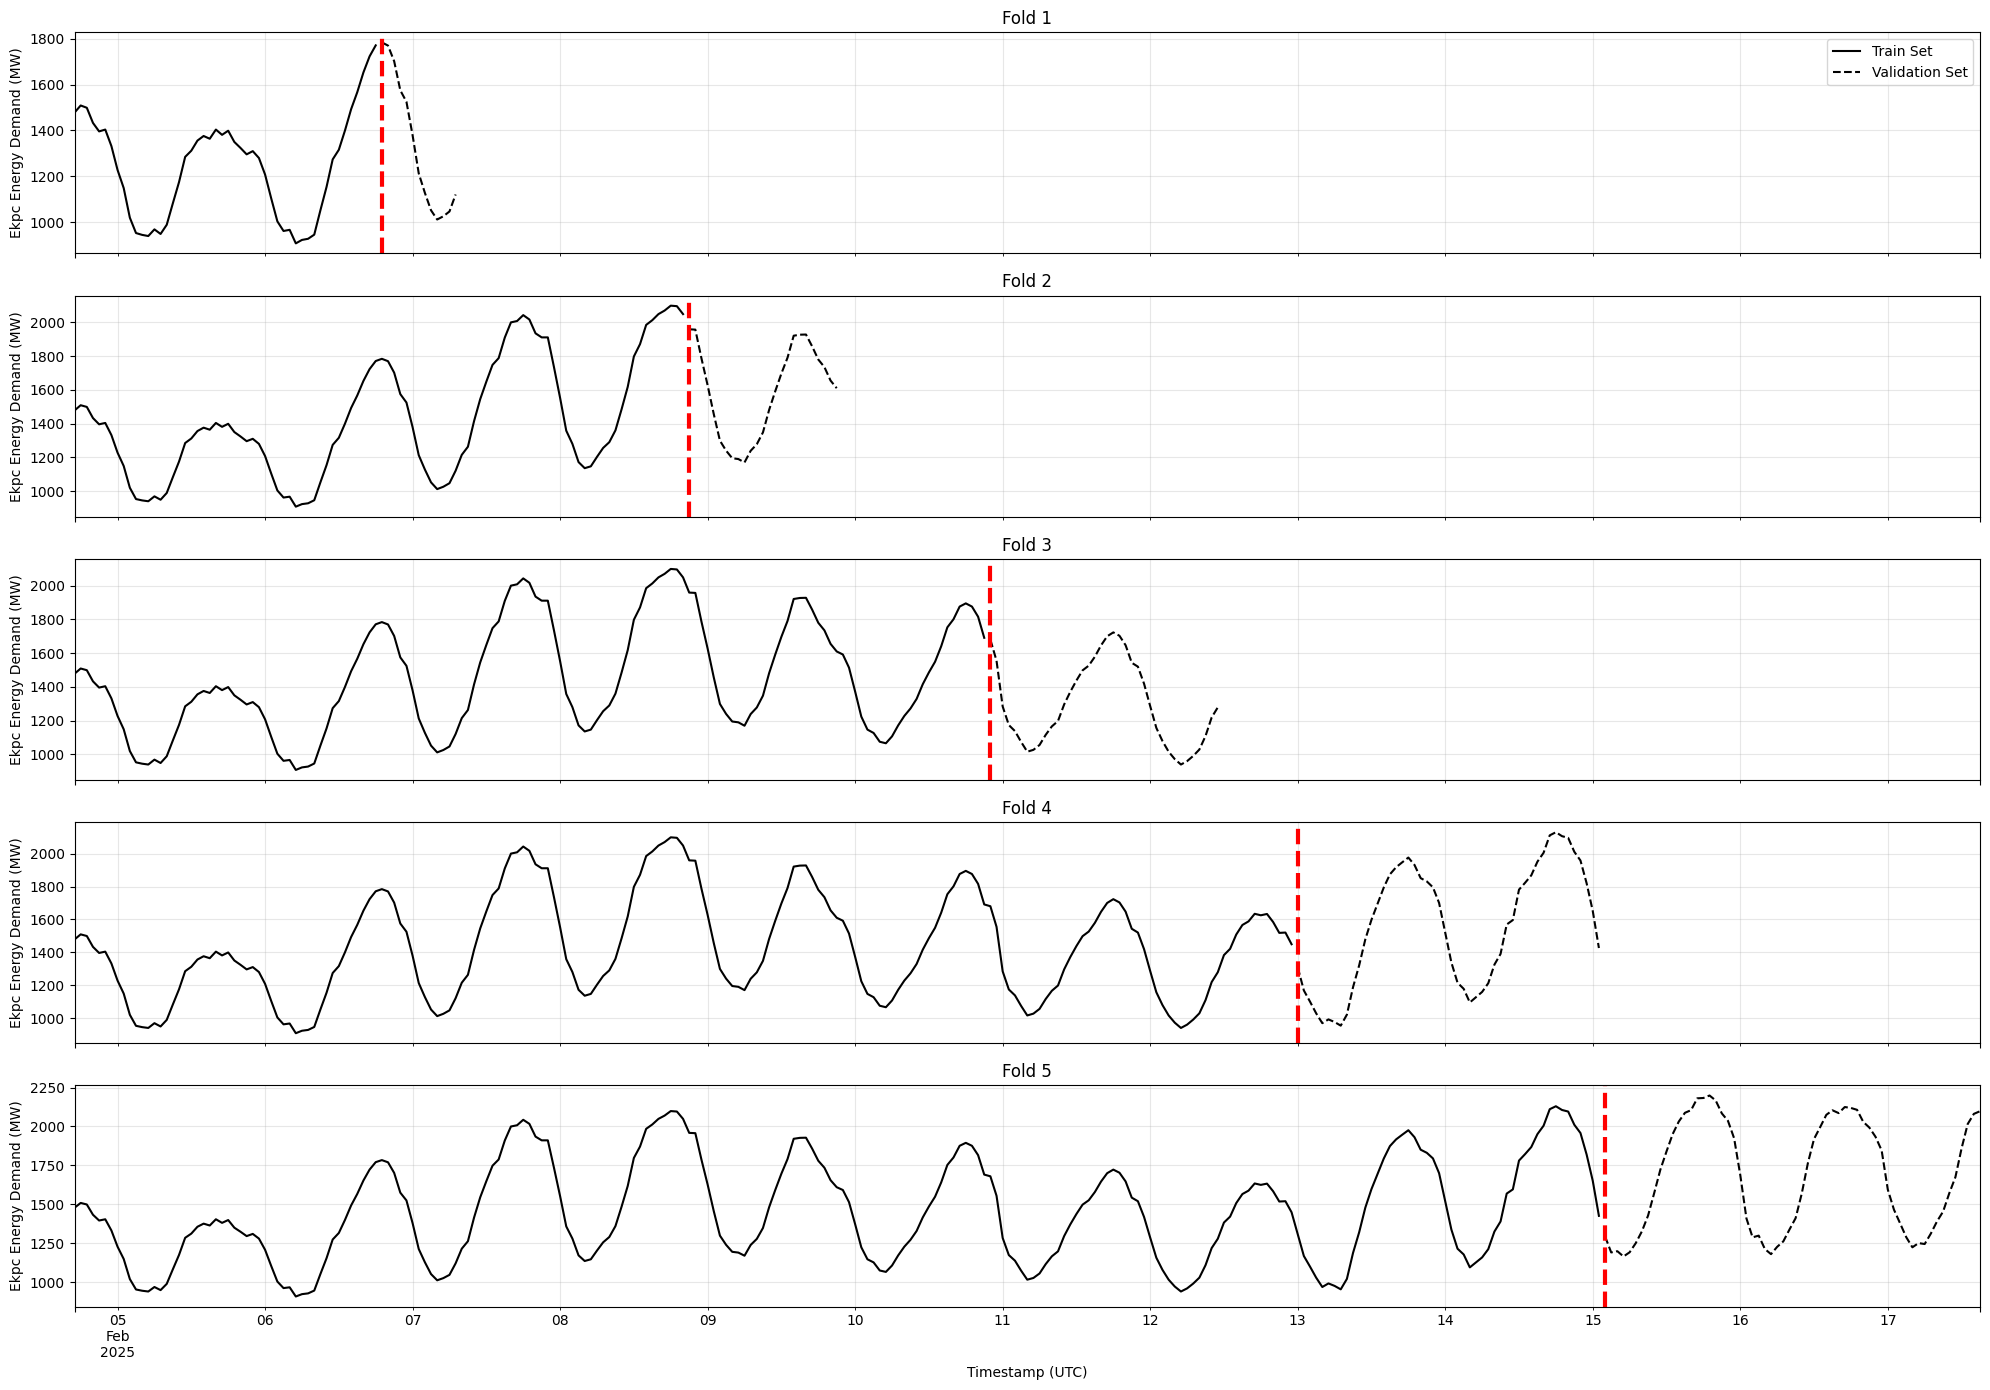

In [6]:
# plot the K-fold walk-forward validation for a randomly selected company ID
df: pd.DataFrame = fetch_data().pipe(transform_data)
df.pipe(
    plot_time_series_splits,
    random.choice(df["company_id"].unique())
)

In [7]:
# load the current forecasting model
load_model()

LGBMRegressor(learning_rate=0.17326859672437625, max_depth=8,
              min_data_in_leaf=21, n_estimators=148, num_leaves=43,
              verbosity=-1)

In [8]:
# backtest the current forecasting model
_, response = backtest_model(random.choice(range(4, 25)))
response

2025-02-17 09:44:49.325 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-17 09:44:50.157 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-17 09:44:50.158 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.
2025-02-17 09:44:50.573 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 1 hour forecast.
2025-02-17 09:44:50.758 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 2 hour forecast.
2025-02-17 09:44:50.973 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 3 hour forecast.
2025-02-17 09:44:51.238 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 4 hour forecast.
2025-02-17 09:44:51.543 | INFO     | src.inference:generate_multi_step_forecast:15

'pass'

In [9]:
# evaluate the current forecasting model
evaluate_model()

2025-02-17 09:45:03.156 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-17 09:45:03.978 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-17 09:45:03.979 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.
2025-02-17 09:45:04.380 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 1 hour forecast.
2025-02-17 09:45:04.543 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 2 hour forecast.
2025-02-17 09:45:04.750 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 3 hour forecast.
2025-02-17 09:45:05.059 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 4 hour forecast.
2025-02-17 09:45:05.361 | INFO     | src.inference:generate_multi_step_forecast:15

### **`Inference pipeline`**

In [10]:
df: pd.DataFrame = fetch_data().pipe(transform_data)

# a dictionary that maps each company ID to its split
horizon: int = 12
time_delta: pd.Timedelta = pd.Timedelta(hours=horizon)
splits: dict[str, pd.Timestamp] = {
    company_id: df.query(f"company_id == '{company_id}'")["timestamp_utc"].max() - time_delta
    for company_id in sorted(df["company_id"].unique())
}

# iterate over each company ID and create its train and test set
dfs: list[tuple[pd.DataFrame, pd.DataFrame]] = [
    (
        df.query(
            f"company_id == '{company_id}' & \
            timestamp_utc <= @pd.Timestamp('{split}')"
        ),
        df.query(
            f"company_id == '{company_id}' & \
            timestamp_utc > @pd.Timestamp('{split}')"
        )
    )
    for company_id, split in splits.items()
]

# vertically concatenate the train sets into a single train set; do the same for the test sets
df_train: pd.DataFrame = pd.concat([tup[0] for tup in dfs], axis=0, ignore_index=True)
df_test: pd.DataFrame = pd.concat([tup[1] for tup in dfs], axis=0, ignore_index=True)

2025-02-17 09:45:12.171 | INFO     | src.data:fetch_data:39 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-17 09:45:12.984 | INFO     | src.data:fetch_data:117 - The raw data has been pre-processed and validated.
2025-02-17 09:45:12.986 | INFO     | src.data:transform_data:233 - Transforming the pre-processed data into features and targets.


In [11]:
# a dictionary to map each company ID to its last known value, i.e., the train set's last value
naive_forecaster: dict[str, float] = {
    company_id: (
        df
        .query(f"company_id == '{company_id}' & timestamp_utc == @pd.Timestamp('{split}')")
        ["energy_demand_mw"]
        .squeeze()
    )
    for company_id, split in splits.items()
}
naive_forecaster

{'aep': 13301.0,
 'comed': 8935.0,
 'dayton': 1627.0,
 'deok': 2697.0,
 'dom': 8144.0,
 'duq': 1453.0,
 'ekpc': 1251.0,
 'fe': 7376.0,
 'ni': 10331.0,
 'pjme': 22472.0,
 'pjmw': 4052.0}

In [12]:
df_forecast: pd.DataFrame = (
    df_test
    .assign(naive_forecast=df_test["company_id"].map(naive_forecaster))
    .merge(
        df_train.pipe(generate_multi_step_forecast, forecast_horizon=horizon),
        how="inner",
        on=["company_id", "timestamp_utc"]
    )
    .rename(columns={"energy_demand_mw": "target", "forecast": "model_forecast"})
    [[
        "company_id",
        "timestamp_utc",
        "target",
        "naive_forecast",
        "model_forecast"
    ]]
)
df_forecast

2025-02-17 09:45:22.223 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 12 hour forecast.


company_id       timestamp_utc   target  naive_forecast  model_forecast
0          aep 2025-02-17 06:00:00  14090.0         13301.0         14047.0
1          aep 2025-02-17 07:00:00  15790.0         13301.0         15529.0
2          aep 2025-02-17 08:00:00  16594.0         13301.0         16206.0
3          aep 2025-02-17 09:00:00  16440.0         13301.0         16406.0
4          aep 2025-02-17 10:00:00  16345.0         13301.0         16554.0
..         ...                 ...      ...             ...             ...
127       pjmw 2025-02-17 13:00:00   5143.0          4052.0          5104.0
128       pjmw 2025-02-17 14:00:00   5099.0          4052.0          5078.0
129       pjmw 2025-02-17 15:00:00   4982.0          4052.0          5030.0
130       pjmw 2025-02-17 16:00:00   4922.0          4052.0          5030.0
131       pjmw 2025-02-17 17:00:00   4858.0          4052.0          5049.0

[132 rows x 5 columns]

In [13]:
# compare the naive forecast to the model's forecast
y: pd.Series = df_forecast["target"]
naive_metric: float = compute_metrics(y, df_forecast["naive_forecast"]).get("r_squared")
model_metric: float = compute_metrics(y, df_forecast["model_forecast"]).get("r_squared")
print(f"{horizon}-Hour Forecast\nNaive R²: {naive_metric}\nModel R²: {model_metric}")

12-Hour Forecast
Naive R²: 0.8566
Model R²: 0.9994


In [14]:
# plot the target, the model's forecast, and naive forecast for each company ID
figs: list[Figure] = [
    px.line(
        (
            df_forecast
            .query(f"company_id == '{company_id}'")
            .rename(columns={
                "target": "Target",
                "model_forecast": "Multi-Step Forecast",
                "naive_forecast": "Naive Forecast"
            })
        ),
        x="timestamp_utc",
        y=["Target", "Multi-Step Forecast", "Naive Forecast"],
        color_discrete_sequence=["green", "blue", "red"],
        labels={
            "timestamp_utc": "Timestamp (UTC)",
            "value": "Energy Demand (MW)",
            "variable": "Company ID"
        },
        markers=True,
        title=f"{company_id.title()} Hourly Energy Demand",
        template="plotly_dark"
    )
    for company_id in sorted(df_forecast["company_id"].unique())
]
_ = [fig.show() for fig in figs]

In [ ]:
# a class that encapsulates the energy demand forecasting pipeline
class ForecastingPipeline:
    def __init__(self, forecast_horizon: int):
        self.forecast_horizon: int = forecast_horizon
    
    def __str__(self):
        return f"{self.forecast_horizon}-hour forecast"

    def run(self) -> pd.DataFrame:
        return (
            fetch_data()
            .pipe(transform_data)
            .pipe(generate_multi_step_forecast, self.forecast_horizon)
        )

# instantiate an object of tyep, 'ForecastingPipeline'
fp: ForecastingPipeline = ForecastingPipeline(horizon)
display(
    fp.forecast_horizon, fp.__str__(), fp.run()
)